# BHAI VAE: Semi-Supervised Variational Autoencoder for Ocean Drilling Data

This notebook implements the complete analysis pipeline for the BHAI VAE paper:

1. **Data Pipeline**: Download from Zenodo, process to 20cm bins
2. **Descriptive Figures**: Expedition map, dataset overview, lithology counts, variable distributions
3. **Model Training**: Unsupervised and Semi-supervised VAE with masked encoding
4. **Model Evaluation**: SVM classification, clustering metrics (ARI), reconstruction quality
5. **Evaluation Figures**: Reconstruction scatter, ROC comparison, UMAP visualization
6. **Network Diagrams**: Architecture visualization from PyTorch specs

## 1. Setup and Imports

In [1]:
# Core libraries
import os
import sys
import random
import warnings
from pathlib import Path
from datetime import datetime

# Data
import numpy as np
import pandas as pd

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (r2_score, roc_curve, auc, accuracy_score, 
                             precision_recall_fscore_support, adjusted_rand_score,
                             classification_report, confusion_matrix)
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans

# UMAP
import umap

# Progress
from tqdm.auto import tqdm

# Download
import requests
import zipfile

# Mapping
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except ImportError:
    HAS_CARTOPY = False
    print("Warning: cartopy not available, expedition map will be skipped")

warnings.filterwarnings('ignore')

# Add models directory to path
sys.path.insert(0, str(Path.cwd().parent))
from models.vae import VAE, SemiSupervisedVAE, DistributionAwareScaler, FEATURE_COLS

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA RTX 6000 Ada Generation


## 2. Configuration

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Reproducibility
SEED = 42

# Paths
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODEL_DIR = BASE_DIR / "models"
FIGURES_DIR = BASE_DIR / "figures"

# Create directories
for d in [RAW_DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Data source
ZENODO_DOI = "10.5281/zenodo.7484524"
ZENODO_RECORD_ID = "7484524"

# Model architecture
INPUT_DIM = 6
LATENT_DIM = 10
HIDDEN_DIMS = [64, 32]

# Training hyperparameters
N_EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
MASK_RATIO = 0.10  # 10% masked encoding

# Annealing schedules
BETA_START = 1e-10
BETA_END = 0.075
BETA_ANNEAL_EPOCHS = 50

ALPHA_START = 0.0
ALPHA_END = 0.01
ALPHA_ANNEAL_EPOCHS = 50

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Feature columns
FEATURE_COLUMNS = [
    "Bulk density (GRA)",
    "Magnetic susceptibility (instr. units)",
    "NGR total counts (cps)",
    "R", "G", "B"
]

FEATURE_NAMES_SHORT = ['Bulk Density', 'Mag. Susc.', 'NGR', 'R', 'G', 'B']

print(f"Configuration loaded")
print(f"  Device: {DEVICE}")
print(f"  Base dir: {BASE_DIR}")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Mask ratio: {MASK_RATIO}")

Configuration loaded
  Device: cuda:0
  Base dir: /home/mnky9800n/clawd/bhai-vae-paper
  Epochs: 100
  Batch size: 256
  Mask ratio: 0.1


In [3]:
# Set random seeds for reproducibility
def set_seed(seed=SEED):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 42


## 3. Data Download from Zenodo

In [4]:
def download_from_zenodo(record_id, output_dir, files_to_download=None):
    """
    Download files from Zenodo record.
    
    Parameters
    ----------
    record_id : str
        Zenodo record ID (e.g., "7484524")
    output_dir : Path
        Directory to save downloaded files
    files_to_download : list, optional
        Specific files to download. If None, downloads all files.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Get record metadata
    api_url = f"https://zenodo.org/api/records/{record_id}"
    response = requests.get(api_url)
    response.raise_for_status()
    record = response.json()
    
    print(f"Record: {record['metadata']['title']}")
    print(f"DOI: {record['doi']}")
    print(f"Files available: {len(record['files'])}")
    
    downloaded = []
    for file_info in record['files']:
        filename = file_info['key']
        
        # Filter files if specified
        if files_to_download and filename not in files_to_download:
            continue
            
        output_path = output_dir / filename
        
        # Skip if already exists
        if output_path.exists():
            print(f"  {filename} already exists, skipping")
            downloaded.append(output_path)
            continue
        
        # Download
        print(f"  Downloading {filename} ({file_info['size'] / 1e6:.1f} MB)...")
        download_url = file_info['links']['self']
        
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            
            with open(output_path, 'wb') as f:
                with tqdm(total=total_size, unit='B', unit_scale=True, desc=filename) as pbar:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
                        pbar.update(len(chunk))
        
        downloaded.append(output_path)
        print(f"    Saved to {output_path}")
    
    return downloaded

In [5]:
# Files we need from Zenodo
ZENODO_FILES = [
    "GRA_DataLITH.csv",
    "MS_DataLITH.csv",
    "NGR_DataLITH.csv",
    "RSC_DataLITH.csv"  # Contains L*a*b* and RGB
]

# Check if raw data exists, download if not
raw_files_exist = all((RAW_DATA_DIR / f).exists() for f in ZENODO_FILES)

if not raw_files_exist:
    print("Downloading raw data from Zenodo...")
    downloaded = download_from_zenodo(ZENODO_RECORD_ID, RAW_DATA_DIR, ZENODO_FILES)
    print(f"\nDownloaded {len(downloaded)} files")
else:
    print("Raw data already exists in", RAW_DATA_DIR)
    for f in ZENODO_FILES:
        path = RAW_DATA_DIR / f
        if path.exists():
            print(f"  {f}: {path.stat().st_size / 1e6:.1f} MB")

Record: Addressing Nigeria's Politico-Structural Contradictions: The Need for State Constitutions and Collegiate Federal Executive
DOI: 10.5281/zenodo.7484524
Files available: 1

Downloaded 0 files


## 4. Data Processing

In [6]:
def process_raw_data(raw_dir, output_path, bin_size_cm=20):
    """
    Process raw LILY data files into training format.
    
    Steps:
    1. Load each measurement type
    2. Create depth bins (default 20cm)
    3. Aggregate measurements within bins (mean)
    4. Inner join all measurements
    5. Filter for complete samples
    
    Parameters
    ----------
    raw_dir : Path
        Directory containing raw CSV files
    output_path : Path
        Output path for processed CSV
    bin_size_cm : int
        Depth bin size in centimeters
    """
    raw_dir = Path(raw_dir)
    bin_size_m = bin_size_cm / 100.0
    
    print(f"Processing raw data with {bin_size_cm}cm bins...")
    
    # Load GRA (Bulk Density)
    print("  Loading GRA...")
    gra = pd.read_csv(raw_dir / "GRA_DataLITH.csv")
    gra['Depth_Bin'] = (gra['Top depth CSF-A (m)'] // bin_size_m) * bin_size_m
    gra_agg = gra.groupby(['Borehole_ID', 'Depth_Bin']).agg({
        'Bulk density (GRA)': 'mean',
        'Principal': 'first'
    }).reset_index()
    
    # Load MS (Magnetic Susceptibility)
    print("  Loading MS...")
    ms = pd.read_csv(raw_dir / "MS_DataLITH.csv")
    ms['Depth_Bin'] = (ms['Top depth CSF-A (m)'] // bin_size_m) * bin_size_m
    ms_agg = ms.groupby(['Borehole_ID', 'Depth_Bin']).agg({
        'Magnetic susceptibility (instr. units)': 'mean'
    }).reset_index()
    
    # Load NGR
    print("  Loading NGR...")
    ngr = pd.read_csv(raw_dir / "NGR_DataLITH.csv")
    ngr['Depth_Bin'] = (ngr['Top depth CSF-A (m)'] // bin_size_m) * bin_size_m
    ngr_agg = ngr.groupby(['Borehole_ID', 'Depth_Bin']).agg({
        'NGR total counts (cps)': 'mean'
    }).reset_index()
    
    # Load RSC (RGB/L*a*b*)
    print("  Loading RSC...")
    rsc = pd.read_csv(raw_dir / "RSC_DataLITH.csv")
    rsc['Depth_Bin'] = (rsc['Top depth CSF-A (m)'] // bin_size_m) * bin_size_m
    rsc_agg = rsc.groupby(['Borehole_ID', 'Depth_Bin']).agg({
        'R': 'mean', 'G': 'mean', 'B': 'mean'
    }).reset_index()
    
    # Merge all datasets (inner join for complete samples)
    print("  Merging datasets...")
    merged = gra_agg.merge(ms_agg, on=['Borehole_ID', 'Depth_Bin'], how='inner')
    merged = merged.merge(ngr_agg, on=['Borehole_ID', 'Depth_Bin'], how='inner')
    merged = merged.merge(rsc_agg, on=['Borehole_ID', 'Depth_Bin'], how='inner')
    
    # Remove rows with any NaN in features
    feature_cols = ['Bulk density (GRA)', 'Magnetic susceptibility (instr. units)',
                   'NGR total counts (cps)', 'R', 'G', 'B']
    before = len(merged)
    merged = merged.dropna(subset=feature_cols + ['Principal'])
    after = len(merged)
    
    print(f"  Samples: {before} -> {after} (dropped {before - after} incomplete)")
    
    # Save
    merged.to_csv(output_path, index=False)
    print(f"  Saved to {output_path}")
    
    return merged

In [7]:
# Use existing processed data or process from raw
PROCESSED_DATA_PATH = DATA_DIR / "vae_training_data_v2_20cm.csv"

if PROCESSED_DATA_PATH.exists():
    print(f"Loading existing processed data from {PROCESSED_DATA_PATH}")
    df = pd.read_csv(PROCESSED_DATA_PATH)
else:
    print("Processing raw data...")
    df = process_raw_data(RAW_DATA_DIR, PROCESSED_DATA_PATH, bin_size_cm=20)

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample counts by lithology (top 10):")
print(df['Principal'].value_counts().head(10))

Loading existing processed data from /home/mnky9800n/clawd/bhai-vae-paper/data/vae_training_data_v2_20cm.csv

Dataset shape: (238506, 9)
Columns: ['Borehole_ID', 'Depth_Bin', 'Bulk density (GRA)', 'Principal', 'Magnetic susceptibility (instr. units)', 'NGR total counts (cps)', 'R', 'G', 'B']

Sample counts by lithology (top 10):
Principal
nannofossil ooze     49778
clay                 37237
silty clay           18048
wackestone           14230
packstone            12548
mudstone              9952
claystone             9470
nannofossil chalk     7894
diatom ooze           6095
clayey silt           5406
Name: count, dtype: int64


In [8]:
# Prepare data for training
print("Preparing data for training...")

# Extract features
X_raw = df[FEATURE_COLUMNS].values
print(f"Features shape: {X_raw.shape}")

# Scale using DistributionAwareScaler
scaler = DistributionAwareScaler()
X_scaled = scaler.fit_transform(X_raw)
print(f"Scaled features shape: {X_scaled.shape}")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Principal'].values)
n_classes = len(label_encoder.classes_)
print(f"Number of lithology classes: {n_classes}")

# Extract expedition info
df['Expedition'] = df['Borehole_ID'].str.extract(r'^(\d+)')[0].astype(int)
expeditions = df['Expedition'].unique()
print(f"Number of expeditions: {len(expeditions)}")
print(f"Expeditions: {sorted(expeditions)}")

Preparing data for training...
Features shape: (238506, 6)


Scaled features shape: (238506, 6)
Number of lithology classes: 139


Number of expeditions: 24
Expeditions: [np.int64(346), np.int64(349), np.int64(350), np.int64(351), np.int64(352), np.int64(353), np.int64(354), np.int64(355), np.int64(356), np.int64(359), np.int64(360), np.int64(361), np.int64(362), np.int64(363), np.int64(366), np.int64(367), np.int64(368), np.int64(369), np.int64(371), np.int64(372), np.int64(374), np.int64(375), np.int64(376), np.int64(379)]


## 5. Descriptive Figures

### 5.1 Expedition Map

In [9]:
# IODP expedition coordinates (approximate central locations)
# Based on IODP expedition reports
EXPEDITION_COORDS = {
    346: (40.5, 138.5),   # Asian Monsoon (Sea of Japan)
    349: (15.5, 117.0),   # South China Sea
    350: (32.0, 139.5),   # Izu-Bonin-Mariana
    351: (30.5, 134.5),   # Izu-Bonin-Mariana
    352: (28.5, 141.0),   # Izu-Bonin-Mariana
    353: (8.0, 87.0),     # iMonsoon
    354: (8.0, 88.5),     # Bengal Fan
    355: (22.0, 68.0),    # Arabian Sea Monsoon
    356: (-28.0, 113.0),  # Indonesian Throughflow
    359: (5.0, 73.0),     # Maldives Monsoon and Sea Level
    360: (-42.0, 9.0),    # SW Indian Ridge
    361: (-41.5, -8.0),   # S African Climates
    362: (-2.0, 102.0),   # Sumatra Seismogenesis
    363: (-5.0, 142.0),   # W Pacific Warm Pool
    366: (13.5, 147.0),   # Mariana Convergent Margin
    367: (18.5, 116.5),   # South China Sea Rifted Margin
    368: (19.0, 116.0),   # South China Sea Rifted Margin
    "368X": (19.5, 115.5), # South China Sea Rifted Margin Extension
    369: (-33.5, 104.0),  # Australia Cretaceous Climate
    371: (-34.0, 163.5),  # Tasman Frontier
    372: (-35.0, 174.0),  # Creeping Gas Hydrate Slides
    374: (-77.0, 175.0),  # Ross Sea West Antarctic Ice Sheet
    375: (-39.0, 178.5),  # Hikurangi Subduction Margin
    376: (-37.5, 177.0),  # Brothers Arc Flux
    379: (-57.5, -92.5),  # Amundsen Sea West Antarctic Ice Sheet
}

# Label offsets (tuned for readability - middle ground 3-5)
LABEL_OFFSETS = {
    346: (3, 4),
    349: (4, 3),
    350: (4, 5),
    351: (3, 4),
    352: (5, 3),
    353: (4, 4),
    354: (4, 3),
    355: (3, 5),
    356: (4, 4),
    359: (3, 4),
    360: (4, 3),
    361: (3, 5),
    362: (5, 4),
    363: (4, 3),
    366: (3, 4),
    367: (4, 5),
    368: (3, 4),
    "368X": (4, 3),
    369: (5, 4),
    371: (3, 3),
    372: (4, 4),
    374: (4, 5),
    375: (3, 4),
    376: (4, 3),
    379: (5, 4),
}

if HAS_CARTOPY:
    # Count samples per expedition
    exp_counts = df.groupby('Expedition').size().to_dict()
    
    # Create figure - DPI 300 for publication quality
    fig = plt.figure(figsize=(20, 10), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=150))
    
    # Add map features
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor='#f5f5dc', edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='#add8e6')
    ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.5)
    
    # Add title box with black border
    ax.set_title('IODP Boreholes from the LILY Dataset', fontsize=16, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.9))
    
    # Plot expeditions
    for exp, (lat, lon) in EXPEDITION_COORDS.items():
        exp_int = int(exp) if isinstance(exp, (int, float)) else exp
        count = exp_counts.get(exp_int, exp_counts.get(str(exp), 0))
        
        # Size based on sample count
        size = np.sqrt(count) * 2 + 50
        
        ax.scatter(lon, lat, s=size, c='#cd5c5c', alpha=0.7,
                  transform=ccrs.PlateCarree(), zorder=5, edgecolors='darkred', linewidth=0.5)
        
        # Label with tuned offsets
        dx, dy = LABEL_OFFSETS.get(exp, (3, 3))
        ax.text(lon + dx, lat + dy, str(exp), fontsize=8,
               transform=ccrs.PlateCarree(), zorder=6)
    
    # Smaller legend
    legend_sizes = [1000, 10000, 40000]
    legend_labels = ['1,000', '10,000', '40,000']
    legend_handles = [plt.scatter([], [], s=np.sqrt(s)*2+50, c='#cd5c5c', 
                                  edgecolors='darkred', linewidth=0.5, alpha=0.7)
                     for s in legend_sizes]
    
    legend = ax.legend(legend_handles, legend_labels, 
                      title='Samples', loc='upper right',
                      frameon=True, fontsize=8, title_fontsize=9,
                      markerscale=0.6)
    legend.get_frame().set_alpha(0.9)
    
    plt.savefig(FIGURES_DIR / 'fig_lily_expedition_map.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    print(f"Saved: {FIGURES_DIR / 'fig_lily_expedition_map.png'}")
else:
    print("Skipping expedition map - cartopy not available")

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_lily_expedition_map.png


### 5.2 Dataset Overview

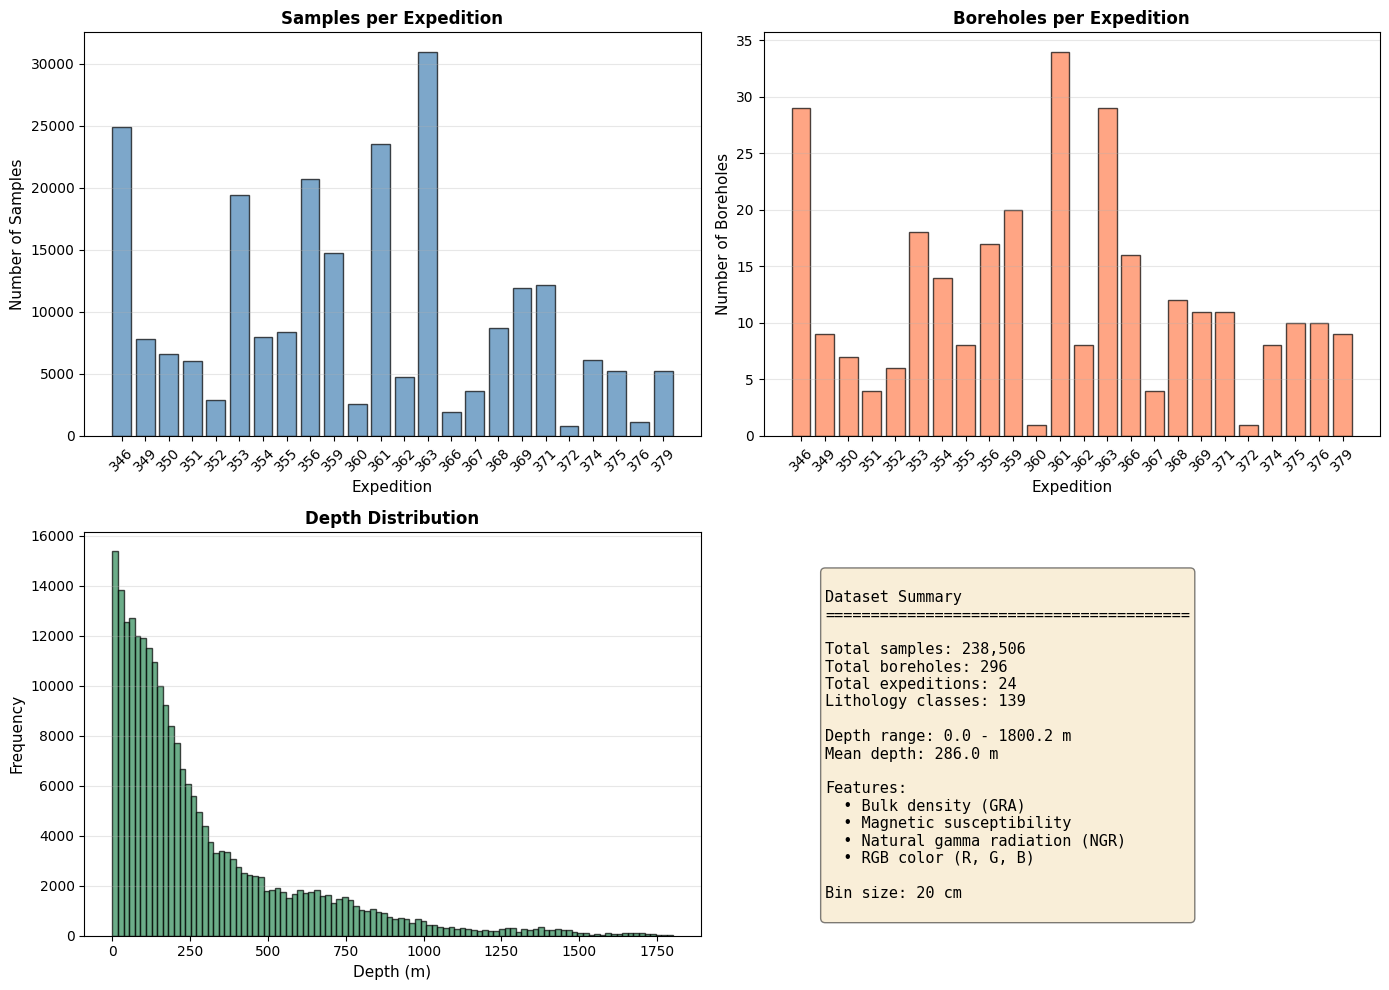

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_lily_dataset.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Samples per expedition
ax = axes[0, 0]
exp_counts = df['Expedition'].value_counts().sort_index()
bars = ax.bar(exp_counts.index.astype(str), exp_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Expedition', fontsize=11)
ax.set_ylabel('Number of Samples', fontsize=11)
ax.set_title('Samples per Expedition', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# Panel 2: Boreholes per expedition
ax = axes[0, 1]
borehole_counts = df.groupby('Expedition')['Borehole_ID'].nunique().sort_index()
ax.bar(borehole_counts.index.astype(str), borehole_counts.values, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Expedition', fontsize=11)
ax.set_ylabel('Number of Boreholes', fontsize=11)
ax.set_title('Boreholes per Expedition', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# Panel 3: Depth distribution
ax = axes[1, 0]
ax.hist(df['Depth_Bin'], bins=100, color='seagreen', edgecolor='black', alpha=0.7)
ax.set_xlabel('Depth (m)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Depth Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Panel 4: Summary statistics text
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
Dataset Summary
{'='*40}

Total samples: {len(df):,}
Total boreholes: {df['Borehole_ID'].nunique():,}
Total expeditions: {df['Expedition'].nunique()}
Lithology classes: {n_classes}

Depth range: {df['Depth_Bin'].min():.1f} - {df['Depth_Bin'].max():.1f} m
Mean depth: {df['Depth_Bin'].mean():.1f} m

Features:
  • Bulk density (GRA)
  • Magnetic susceptibility
  • Natural gamma radiation (NGR)
  • RGB color (R, G, B)

Bin size: 20 cm
"""
ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_lily_dataset.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_lily_dataset.png'}")

### 5.3 Lithology Class Counts

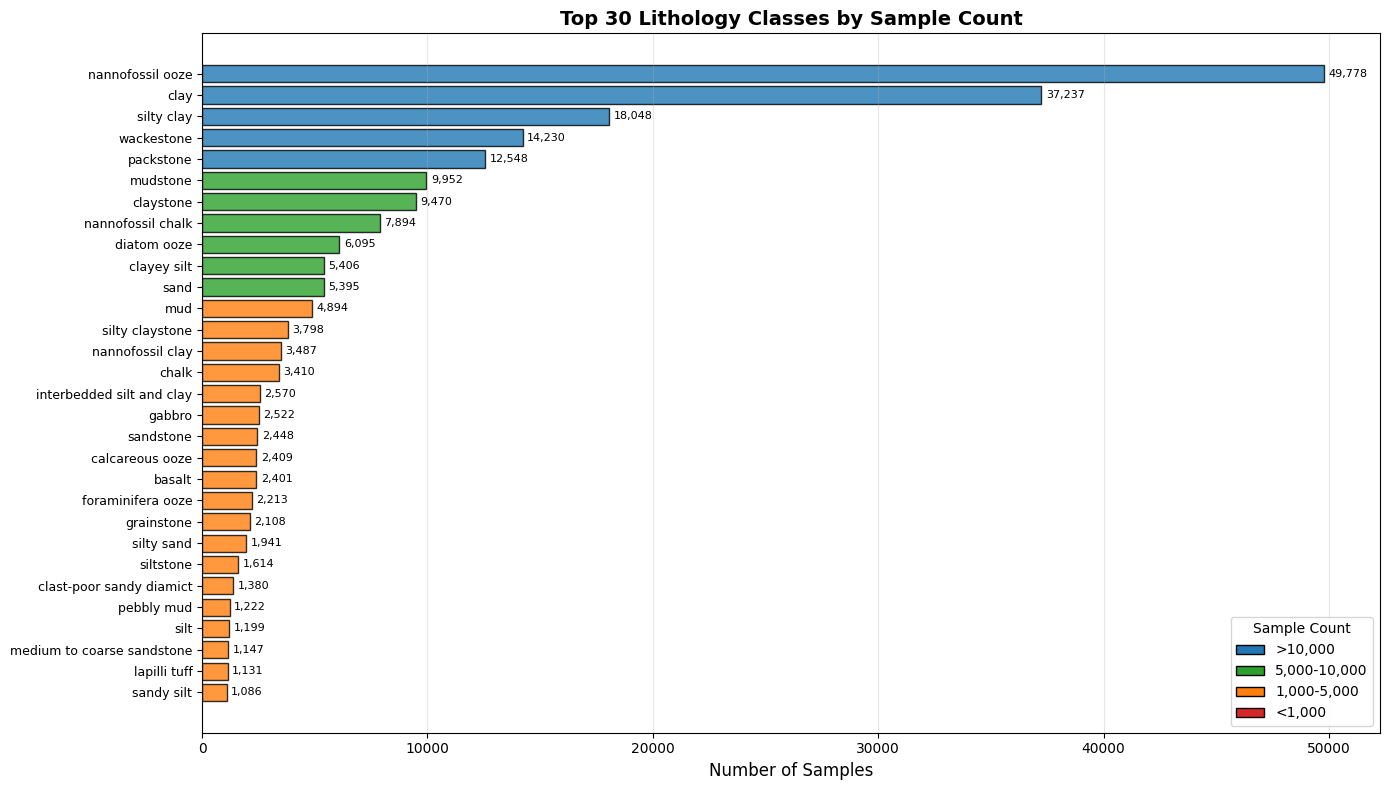

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_lily_lithology_counts.png


In [11]:
fig, ax = plt.subplots(figsize=(14, 8))

# Get top 30 lithology classes
lith_counts = df['Principal'].value_counts().head(30)

# Color by frequency tier
colors = []
for count in lith_counts.values:
    if count > 10000:
        colors.append('#1f77b4')  # Blue for most common
    elif count > 5000:
        colors.append('#2ca02c')  # Green
    elif count > 1000:
        colors.append('#ff7f0e')  # Orange
    else:
        colors.append('#d62728')  # Red for rare

bars = ax.barh(range(len(lith_counts)), lith_counts.values, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(lith_counts)))
ax.set_yticklabels(lith_counts.index, fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_title('Top 30 Lithology Classes by Sample Count', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add count labels
for i, (count, bar) in enumerate(zip(lith_counts.values, bars)):
    ax.text(count + 200, i, f'{count:,}', va='center', fontsize=8)

# Legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='>10,000'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='5,000-10,000'),
    Patch(facecolor='#ff7f0e', edgecolor='black', label='1,000-5,000'),
    Patch(facecolor='#d62728', edgecolor='black', label='<1,000'),
]
ax.legend(handles=legend_elements, title='Sample Count', loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_lily_lithology_counts.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_lily_lithology_counts.png'}")

### 5.4 Variable Distributions

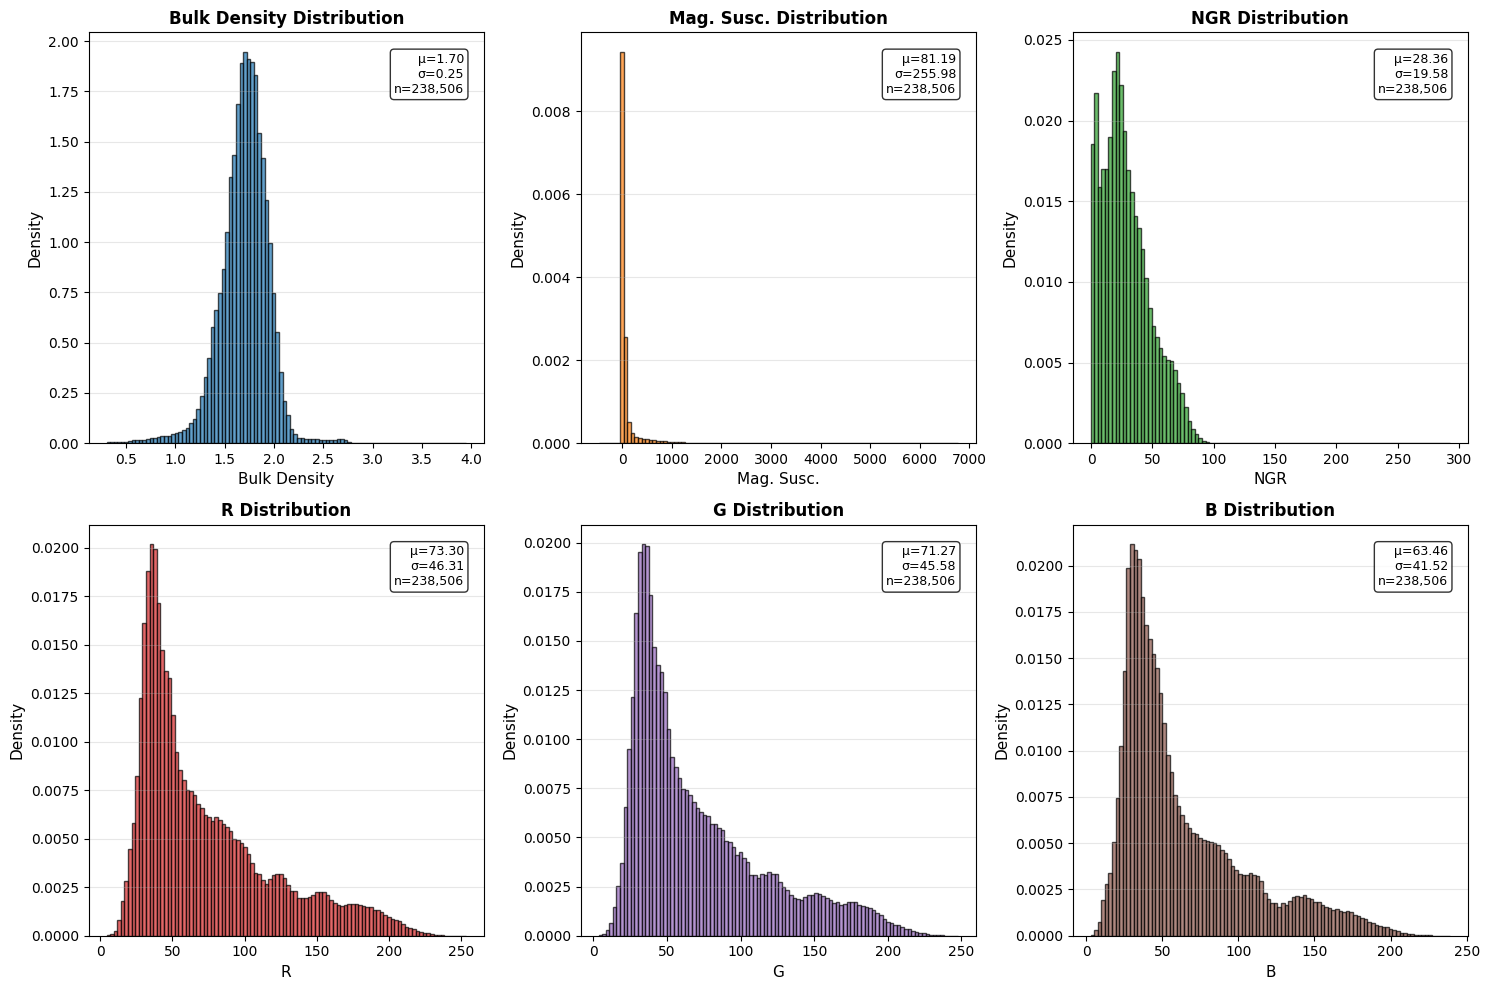

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_lily_variables_dist.png


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, (col, name, color) in enumerate(zip(FEATURE_COLUMNS, FEATURE_NAMES_SHORT, colors)):
    ax = axes[i]
    
    data = df[col].dropna()
    
    # Histogram
    ax.hist(data, bins=100, color=color, edgecolor='black', alpha=0.7, density=True)
    
    # Add statistics
    stats_text = f'μ={data.mean():.2f}\nσ={data.std():.2f}\nn={len(data):,}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel(name, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{name} Distribution', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_lily_variables_dist.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_lily_variables_dist.png'}")

## 6. Model Definitions

Models are imported from `models/vae.py`. Here we verify the architecture.

In [13]:
# Verify model architectures
print("Unsupervised VAE Architecture:")
print("="*50)
model_unsup_test = VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, hidden_dims=HIDDEN_DIMS)
print(model_unsup_test)
print(f"\nTotal parameters: {sum(p.numel() for p in model_unsup_test.parameters()):,}")

print("\n" + "="*50)
print("Semi-Supervised VAE Architecture:")
print("="*50)
model_semisup_test = SemiSupervisedVAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, 
                                        hidden_dims=HIDDEN_DIMS, n_classes=n_classes)
print(model_semisup_test)
print(f"\nTotal parameters: {sum(p.numel() for p in model_semisup_test.parameters()):,}")

Unsupervised VAE Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_mu): Linear(in_features=32, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_out): Linear(in_features=64, out_features=6, bias=True)
)

Total parameters: 6,426

Semi-Supervised VAE Architect

## 7. Training Utilities

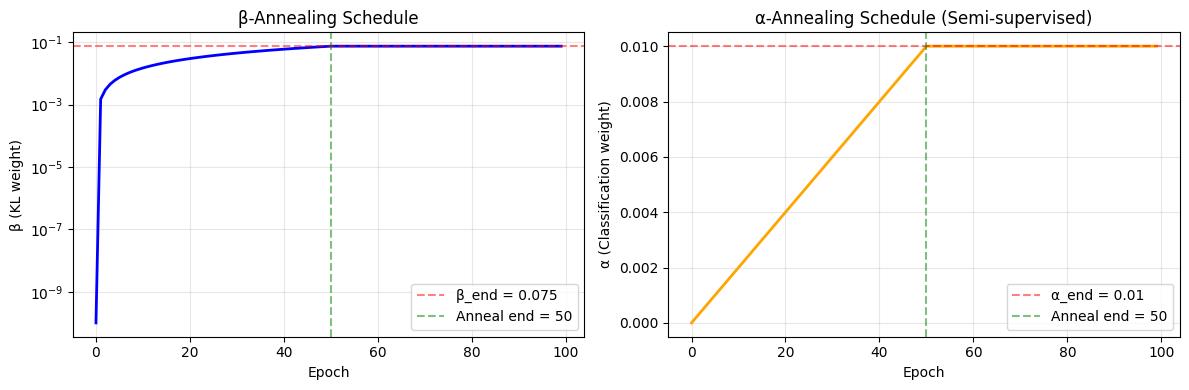

In [14]:
def get_beta(epoch, beta_start=BETA_START, beta_end=BETA_END, anneal_epochs=BETA_ANNEAL_EPOCHS):
    """Get beta value for current epoch (linear annealing)."""
    if epoch >= anneal_epochs:
        return beta_end
    return beta_start + (beta_end - beta_start) * (epoch / anneal_epochs)

def get_alpha(epoch, alpha_start=ALPHA_START, alpha_end=ALPHA_END, anneal_epochs=ALPHA_ANNEAL_EPOCHS):
    """Get alpha value for current epoch (linear annealing)."""
    if epoch >= anneal_epochs:
        return alpha_end
    return alpha_start + (alpha_end - alpha_start) * (epoch / anneal_epochs)

def apply_mask(x, mask_ratio=MASK_RATIO):
    """
    Apply random masking to input tensor.
    
    Randomly sets mask_ratio fraction of values to 0.
    Returns masked tensor and mask.
    """
    mask = torch.rand_like(x) < mask_ratio
    x_masked = x.clone()
    x_masked[mask] = 0
    return x_masked, mask

# Visualize annealing schedules
epochs = np.arange(N_EPOCHS)
betas = [get_beta(e) for e in epochs]
alphas = [get_alpha(e) for e in epochs]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(epochs, betas, 'b-', linewidth=2)
ax.axhline(y=BETA_END, color='r', linestyle='--', alpha=0.5, label=f'β_end = {BETA_END}')
ax.axvline(x=BETA_ANNEAL_EPOCHS, color='g', linestyle='--', alpha=0.5, label=f'Anneal end = {BETA_ANNEAL_EPOCHS}')
ax.set_xlabel('Epoch')
ax.set_ylabel('β (KL weight)')
ax.set_title('β-Annealing Schedule')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(epochs, alphas, 'orange', linewidth=2)
ax.axhline(y=ALPHA_END, color='r', linestyle='--', alpha=0.5, label=f'α_end = {ALPHA_END}')
ax.axvline(x=ALPHA_ANNEAL_EPOCHS, color='g', linestyle='--', alpha=0.5, label=f'Anneal end = {ALPHA_ANNEAL_EPOCHS}')
ax.set_xlabel('Epoch')
ax.set_ylabel('α (Classification weight)')
ax.set_title('α-Annealing Schedule (Semi-supervised)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Train Unsupervised VAE

In [15]:
def train_unsupervised_vae(X, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, 
                           mask_ratio=MASK_RATIO, device=DEVICE):
    """
    Train unsupervised VAE with masked encoding and β-annealing.
    
    Parameters
    ----------
    X : np.ndarray
        Scaled input features
    n_epochs : int
        Number of training epochs
    batch_size : int
        Batch size
    mask_ratio : float
        Fraction of inputs to mask during training
    device : torch.device
        Device to train on
    
    Returns
    -------
    model : VAE
        Trained model
    history : dict
        Training history
    """
    set_seed(SEED)
    
    # Create dataset and dataloader
    dataset = TensorDataset(torch.FloatTensor(X))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                           num_workers=0, pin_memory=True)
    
    # Initialize model
    model = VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, hidden_dims=HIDDEN_DIMS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training history
    history = {'loss': [], 'recon_loss': [], 'kl_loss': [], 'beta': []}
    
    # Training loop
    pbar = tqdm(range(n_epochs), desc='Training Unsup VAE')
    for epoch in pbar:
        model.train()
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0
        n_batches = 0
        
        beta = get_beta(epoch)
        
        for batch in dataloader:
            x_batch = batch[0].to(device)
            
            # Apply masking
            x_masked, mask = apply_mask(x_batch, mask_ratio)
            
            # Forward pass
            optimizer.zero_grad()
            recon, mu, logvar = model(x_masked)
            
            # Loss
            loss, recon_loss, kl_loss = model.loss_function(recon, x_batch, mu, logvar, beta)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()
            n_batches += 1
        
        # Record history
        history['loss'].append(epoch_loss / n_batches)
        history['recon_loss'].append(epoch_recon / n_batches)
        history['kl_loss'].append(epoch_kl / n_batches)
        history['beta'].append(beta)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{epoch_loss/n_batches:.1f}",
            'recon': f"{epoch_recon/n_batches:.1f}",
            'kl': f"{epoch_kl/n_batches:.1f}",
            'β': f"{beta:.2e}"
        })
    
    return model, history

In [16]:
# Train unsupervised VAE
print(f"Training unsupervised VAE on {len(X_scaled):,} samples...")
print(f"  Device: {DEVICE}")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Mask ratio: {MASK_RATIO}")
print(f"  β-annealing: {BETA_START} → {BETA_END} over {BETA_ANNEAL_EPOCHS} epochs")
print()

model_unsup, history_unsup = train_unsupervised_vae(X_scaled)

# Save model
torch.save(model_unsup.state_dict(), MODEL_DIR / 'model_unsup.pt')
print(f"\nModel saved to {MODEL_DIR / 'model_unsup.pt'}")

Training unsupervised VAE on 238,506 samples...
  Device: cuda:0
  Epochs: 100
  Batch size: 256
  Mask ratio: 0.1
  β-annealing: 1e-10 → 0.075 over 50 epochs



Training Unsup VAE:   0%|          | 0/100 [00:00<?, ?it/s]


Model saved to /home/mnky9800n/clawd/bhai-vae-paper/models/model_unsup.pt


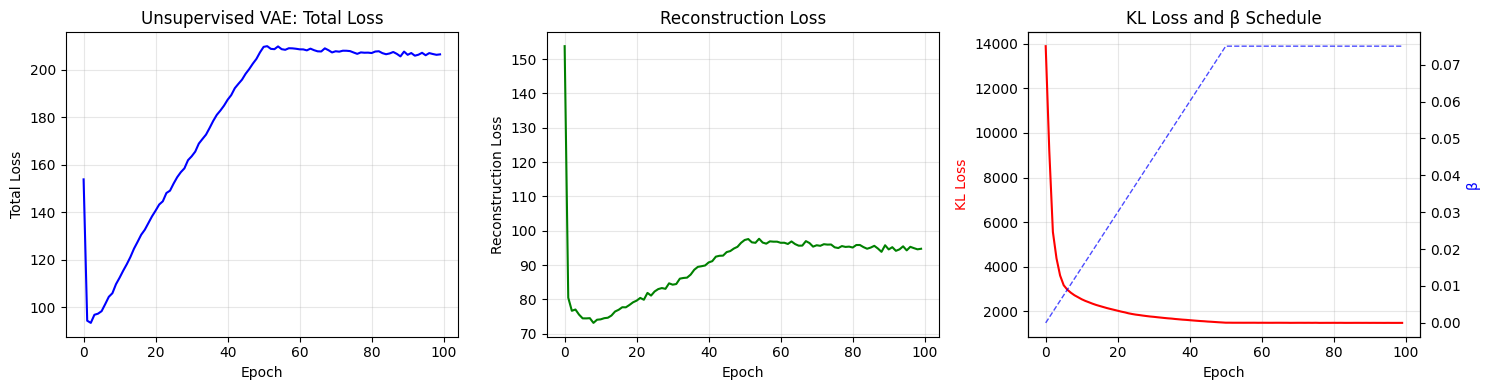

In [17]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(history_unsup['loss'], 'b-', linewidth=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')
ax.set_title('Unsupervised VAE: Total Loss')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(history_unsup['recon_loss'], 'g-', linewidth=1.5, label='Recon Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Reconstruction Loss')
ax.set_title('Reconstruction Loss')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(history_unsup['kl_loss'], 'r-', linewidth=1.5, label='KL Loss')
ax2 = ax.twinx()
ax2.plot(history_unsup['beta'], 'b--', linewidth=1, alpha=0.7, label='β')
ax.set_xlabel('Epoch')
ax.set_ylabel('KL Loss', color='r')
ax2.set_ylabel('β', color='b')
ax.set_title('KL Loss and β Schedule')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Train Semi-Supervised VAE

In [18]:
def train_semisupervised_vae(X, y, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                              mask_ratio=MASK_RATIO, device=DEVICE):
    """
    Train semi-supervised VAE with masked encoding, β-annealing, and α-annealing.
    
    Parameters
    ----------
    X : np.ndarray
        Scaled input features
    y : np.ndarray
        Encoded labels
    n_epochs : int
        Number of training epochs
    batch_size : int
        Batch size
    mask_ratio : float
        Fraction of inputs to mask during training
    device : torch.device
        Device to train on
    
    Returns
    -------
    model : SemiSupervisedVAE
        Trained model
    history : dict
        Training history
    """
    set_seed(SEED)
    
    n_classes = len(np.unique(y))
    
    # Create dataset and dataloader
    dataset = TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                           num_workers=0, pin_memory=True)
    
    # Initialize model
    model = SemiSupervisedVAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM,
                              hidden_dims=HIDDEN_DIMS, n_classes=n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training history
    history = {'loss': [], 'recon_loss': [], 'kl_loss': [], 'class_loss': [], 
               'beta': [], 'alpha': [], 'accuracy': []}
    
    # Training loop
    pbar = tqdm(range(n_epochs), desc='Training Semi-sup VAE')
    for epoch in pbar:
        model.train()
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0
        epoch_class = 0
        epoch_correct = 0
        epoch_total = 0
        n_batches = 0
        
        beta = get_beta(epoch)
        alpha = get_alpha(epoch)
        
        for batch in dataloader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Apply masking
            x_masked, mask = apply_mask(x_batch, mask_ratio)
            
            # Forward pass
            optimizer.zero_grad()
            recon, mu, logvar, logits = model(x_masked)
            
            # Loss
            loss, recon_loss, kl_loss, class_loss = model.loss_function(
                recon, x_batch, mu, logvar, logits, y_batch, beta, alpha
            )
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Accuracy
            _, predicted = torch.max(logits, 1)
            epoch_correct += (predicted == y_batch).sum().item()
            epoch_total += y_batch.size(0)
            
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()
            epoch_class += class_loss.item()
            n_batches += 1
        
        # Record history
        history['loss'].append(epoch_loss / n_batches)
        history['recon_loss'].append(epoch_recon / n_batches)
        history['kl_loss'].append(epoch_kl / n_batches)
        history['class_loss'].append(epoch_class / n_batches)
        history['beta'].append(beta)
        history['alpha'].append(alpha)
        history['accuracy'].append(epoch_correct / epoch_total)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{epoch_loss/n_batches:.1f}",
            'acc': f"{epoch_correct/epoch_total:.3f}",
            'β': f"{beta:.2e}",
            'α': f"{alpha:.3f}"
        })
    
    return model, history

In [19]:
# Train semi-supervised VAE
print(f"Training semi-supervised VAE on {len(X_scaled):,} samples...")
print(f"  Device: {DEVICE}")
print(f"  Classes: {n_classes}")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Mask ratio: {MASK_RATIO}")
print(f"  β-annealing: {BETA_START} → {BETA_END} over {BETA_ANNEAL_EPOCHS} epochs")
print(f"  α-annealing: {ALPHA_START} → {ALPHA_END} over {ALPHA_ANNEAL_EPOCHS} epochs")
print()

model_semisup, history_semisup = train_semisupervised_vae(X_scaled, y)

# Save model
torch.save(model_semisup.state_dict(), MODEL_DIR / 'model_semisup.pt')
print(f"\nModel saved to {MODEL_DIR / 'model_semisup.pt'}")

Training semi-supervised VAE on 238,506 samples...
  Device: cuda:0
  Classes: 139
  Epochs: 100
  Batch size: 256
  Mask ratio: 0.1
  β-annealing: 1e-10 → 0.075 over 50 epochs
  α-annealing: 0.0 → 0.01 over 50 epochs



Training Semi-sup VAE:   0%|          | 0/100 [00:00<?, ?it/s]


Model saved to /home/mnky9800n/clawd/bhai-vae-paper/models/model_semisup.pt


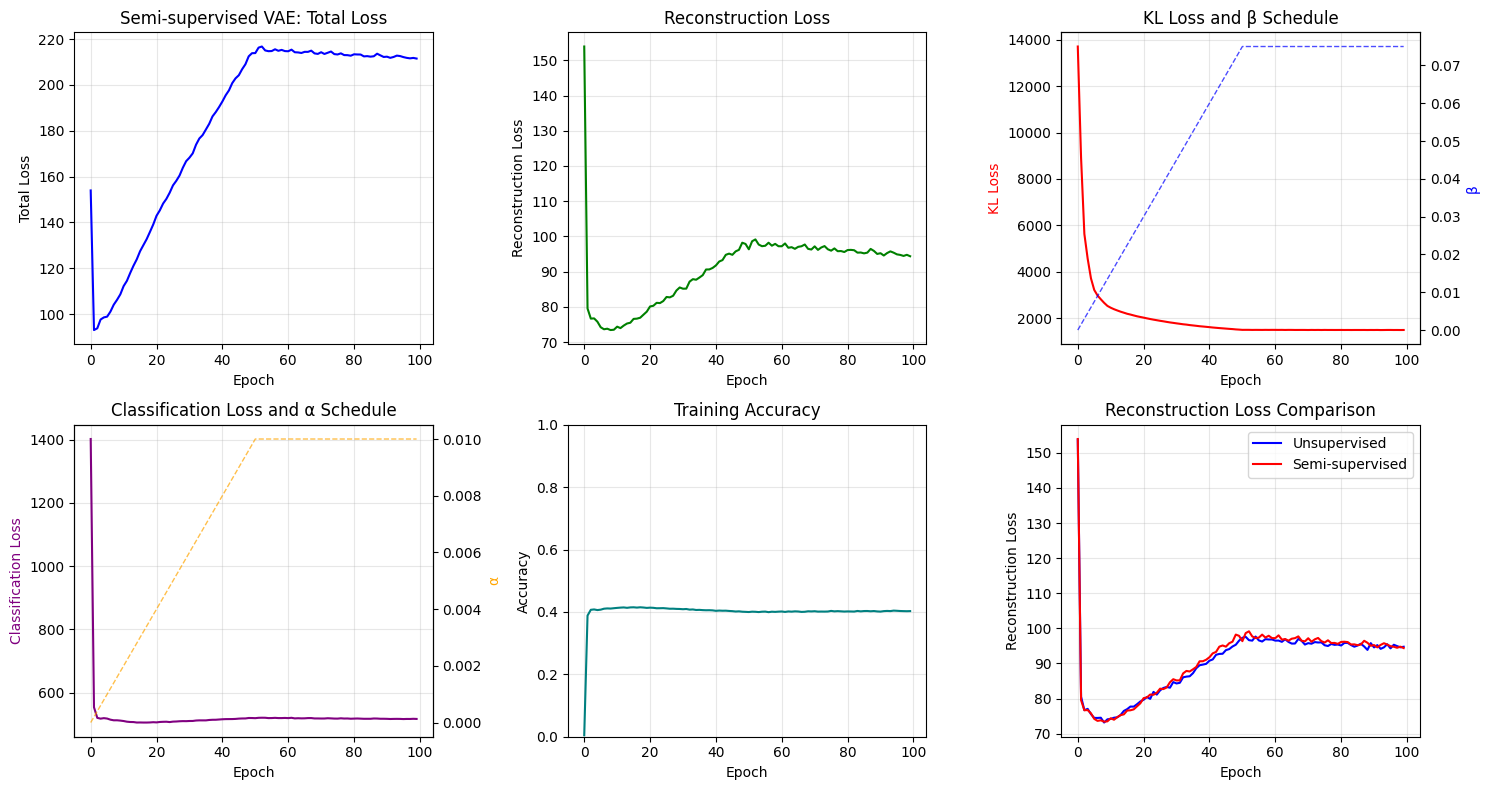

In [20]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

ax = axes[0, 0]
ax.plot(history_semisup['loss'], 'b-', linewidth=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')
ax.set_title('Semi-supervised VAE: Total Loss')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(history_semisup['recon_loss'], 'g-', linewidth=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Reconstruction Loss')
ax.set_title('Reconstruction Loss')
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(history_semisup['kl_loss'], 'r-', linewidth=1.5)
ax2 = ax.twinx()
ax2.plot(history_semisup['beta'], 'b--', linewidth=1, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('KL Loss', color='r')
ax2.set_ylabel('β', color='b')
ax.set_title('KL Loss and β Schedule')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(history_semisup['class_loss'], 'purple', linewidth=1.5)
ax2 = ax.twinx()
ax2.plot(history_semisup['alpha'], 'orange', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Classification Loss', color='purple')
ax2.set_ylabel('α', color='orange')
ax.set_title('Classification Loss and α Schedule')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(history_semisup['accuracy'], 'teal', linewidth=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Compare both models
ax = axes[1, 2]
ax.plot(history_unsup['recon_loss'], 'b-', linewidth=1.5, label='Unsupervised')
ax.plot(history_semisup['recon_loss'], 'r-', linewidth=1.5, label='Semi-supervised')
ax.set_xlabel('Epoch')
ax.set_ylabel('Reconstruction Loss')
ax.set_title('Reconstruction Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Evaluation Utilities

In [21]:
def get_embeddings(model, X, device=DEVICE):
    """Extract embeddings from model."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        embeddings = model.get_embeddings(X_tensor).cpu().numpy()
    return embeddings

def get_reconstructions(model, X, device=DEVICE):
    """Get reconstructions using deterministic encoding (mu)."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        mu, _ = model.encode(X_tensor)
        recon = model.decode(mu)
    return recon.cpu().numpy()

def get_predictions(model, X, device=DEVICE):
    """Get class predictions from semi-supervised model."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        mu, _ = model.encode(X_tensor)
        logits = model.classify(mu)
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(logits, 1)
    return preds.cpu().numpy(), probs.cpu().numpy()

def compute_ari(embeddings, y, k_values=[10, 12, 15, 20]):
    """Compute Adjusted Rand Index for k-means clustering."""
    results = {}
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        clusters = kmeans.fit_predict(embeddings)
        ari = adjusted_rand_score(y, clusters)
        results[k] = ari
    return results

## 11. Evaluate Models

In [22]:
# Extract embeddings and reconstructions
print("Extracting embeddings and reconstructions...")

emb_unsup = get_embeddings(model_unsup, X_scaled)
emb_semisup = get_embeddings(model_semisup, X_scaled)

recon_unsup = get_reconstructions(model_unsup, X_scaled)
recon_semisup = get_reconstructions(model_semisup, X_scaled)

print(f"  Unsupervised embeddings: {emb_unsup.shape}")
print(f"  Semi-supervised embeddings: {emb_semisup.shape}")

# Save embeddings
np.savez(MODEL_DIR / 'embeddings.npz',
         unsup=emb_unsup, semisup=emb_semisup, y=y)
print(f"\nEmbeddings saved to {MODEL_DIR / 'embeddings.npz'}")

Extracting embeddings and reconstructions...
  Unsupervised embeddings: (238506, 10)
  Semi-supervised embeddings: (238506, 10)

Embeddings saved to /home/mnky9800n/clawd/bhai-vae-paper/models/embeddings.npz


In [23]:
# Reconstruction quality (R²)
print("\nReconstruction Quality (R²):")
print("="*50)

r2_results = {'Feature': [], 'Unsupervised': [], 'Semi-supervised': []}

for i, name in enumerate(FEATURE_NAMES_SHORT):
    r2_unsup = r2_score(X_scaled[:, i], recon_unsup[:, i])
    r2_semisup = r2_score(X_scaled[:, i], recon_semisup[:, i])
    
    r2_results['Feature'].append(name)
    r2_results['Unsupervised'].append(r2_unsup)
    r2_results['Semi-supervised'].append(r2_semisup)
    
    print(f"  {name:15s}: Unsup R² = {r2_unsup:.4f}, Semi-sup R² = {r2_semisup:.4f}")

# Overall
r2_overall_unsup = r2_score(X_scaled.flatten(), recon_unsup.flatten())
r2_overall_semisup = r2_score(X_scaled.flatten(), recon_semisup.flatten())
print(f"\n  {'Overall':15s}: Unsup R² = {r2_overall_unsup:.4f}, Semi-sup R² = {r2_overall_semisup:.4f}")

r2_df = pd.DataFrame(r2_results)
r2_df


Reconstruction Quality (R²):
  Bulk Density   : Unsup R² = 0.9855, Semi-sup R² = 0.9848
  Mag. Susc.     : Unsup R² = 0.9847, Semi-sup R² = 0.9831
  NGR            : Unsup R² = 0.9840, Semi-sup R² = 0.9862
  R              : Unsup R² = 0.9930, Semi-sup R² = 0.9936
  G              : Unsup R² = 0.9979, Semi-sup R² = 0.9977
  B              : Unsup R² = 0.9922, Semi-sup R² = 0.9913

  Overall        : Unsup R² = 0.9895, Semi-sup R² = 0.9894


,Feature,Unsupervised,Semi-supervised
0,Bulk Density,0.985472,0.984762
1,Mag. Susc.,0.984739,0.983051
2,NGR,0.983988,0.986179
3,R,0.992993,0.993583
4,G,0.997857,0.997670
5,B,0.992219,0.991308


In [24]:
# Clustering metrics (ARI)
print("\nClustering Quality (ARI):")
print("="*50)

ari_unsup = compute_ari(emb_unsup, y)
ari_semisup = compute_ari(emb_semisup, y)

print("\nUnsupervised VAE:")
for k, ari in ari_unsup.items():
    print(f"  k={k}: ARI = {ari:.4f}")

print("\nSemi-supervised VAE:")
for k, ari in ari_semisup.items():
    print(f"  k={k}: ARI = {ari:.4f}")


Clustering Quality (ARI):



Unsupervised VAE:
  k=10: ARI = 0.1425
  k=12: ARI = 0.1318
  k=15: ARI = 0.1332
  k=20: ARI = 0.1274

Semi-supervised VAE:
  k=10: ARI = 0.1450
  k=12: ARI = 0.1323
  k=15: ARI = 0.1299
  k=20: ARI = 0.1247


In [25]:
# SVM classification on unsupervised embeddings
print("\nSVM Classification on Unsupervised Embeddings:")
print("="*50)

# Use subset for faster SVM training, filtering for classes with >=2 samples
n_svm_samples = min(50000, len(y))
svm_idx = np.random.choice(len(y), n_svm_samples, replace=False)

# Filter to keep only classes with >=2 samples (required for stratified split)
class_counts_svm = pd.Series(y[svm_idx]).value_counts()
valid_classes = class_counts_svm[class_counts_svm >= 2].index.values
valid_mask = np.isin(y[svm_idx], valid_classes)
svm_idx_filtered = svm_idx[valid_mask]

print(f"Filtered from {len(svm_idx):,} to {len(svm_idx_filtered):,} samples")
print(f"(keeping classes with >=2 samples for stratified split)")

# Train/test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    emb_unsup[svm_idx_filtered], y[svm_idx_filtered], test_size=0.2, 
    random_state=SEED, stratify=y[svm_idx_filtered]
)

print(f"Training SVM on {len(X_train_svm):,} samples...")
svm = SVC(kernel='rbf', C=1.0, random_state=SEED)
svm.fit(X_train_svm, y_train_svm)

y_pred_svm = svm.predict(X_test_svm)
acc_svm = accuracy_score(y_test_svm, y_pred_svm)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_svm, y_pred_svm, average='weighted')

print(f"\nSVM Results (on unsupervised embeddings):")
print(f"  Accuracy:  {acc_svm:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1:        {f1:.4f}")


SVM Classification on Unsupervised Embeddings:
Filtered from 50,000 to 49,984 samples
(keeping classes with >=2 samples for stratified split)
Training SVM on 39,987 samples...



SVM Results (on unsupervised embeddings):
  Accuracy:  0.5255
  Precision: 0.4807
  Recall:    0.5255
  F1:        0.4768


In [26]:
# Semi-supervised classification head evaluation
print("\nSemi-supervised Classification Head Evaluation:")
print("="*50)

y_pred_semisup, y_prob_semisup = get_predictions(model_semisup, X_scaled)

acc_semisup = accuracy_score(y, y_pred_semisup)
precision_ss, recall_ss, f1_ss, _ = precision_recall_fscore_support(y, y_pred_semisup, average='weighted')

print(f"\nClassification Head Results:")
print(f"  Accuracy:  {acc_semisup:.4f}")
print(f"  Precision: {precision_ss:.4f}")
print(f"  Recall:    {recall_ss:.4f}")
print(f"  F1:        {f1_ss:.4f}")


Semi-supervised Classification Head Evaluation:

Classification Head Results:
  Accuracy:  0.4539
  Precision: 0.3951
  Recall:    0.4539
  F1:        0.3818


In [27]:
# Summary comparison
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

comparison_data = {
    'Metric': ['R² (overall)', 'Accuracy', 'Precision', 'Recall', 'F1', f'ARI (k={list(ari_unsup.keys())[0]})'],
    'Unsupervised (SVM)': [r2_overall_unsup, acc_svm, precision, recall, f1, list(ari_unsup.values())[0]],
    'Semi-supervised': [r2_overall_semisup, acc_semisup, precision_ss, recall_ss, f1_ss, list(ari_semisup.values())[0]]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


MODEL COMPARISON SUMMARY
      Metric  Unsupervised (SVM)  Semi-supervised
R² (overall)            0.989545         0.989426
    Accuracy            0.525458         0.453938
   Precision            0.480722         0.395104
      Recall            0.525458         0.453938
          F1            0.476797         0.381803
  ARI (k=10)            0.142467         0.145021


## 12. Evaluation Figures

### 12.1 Reconstruction Scatter Plot

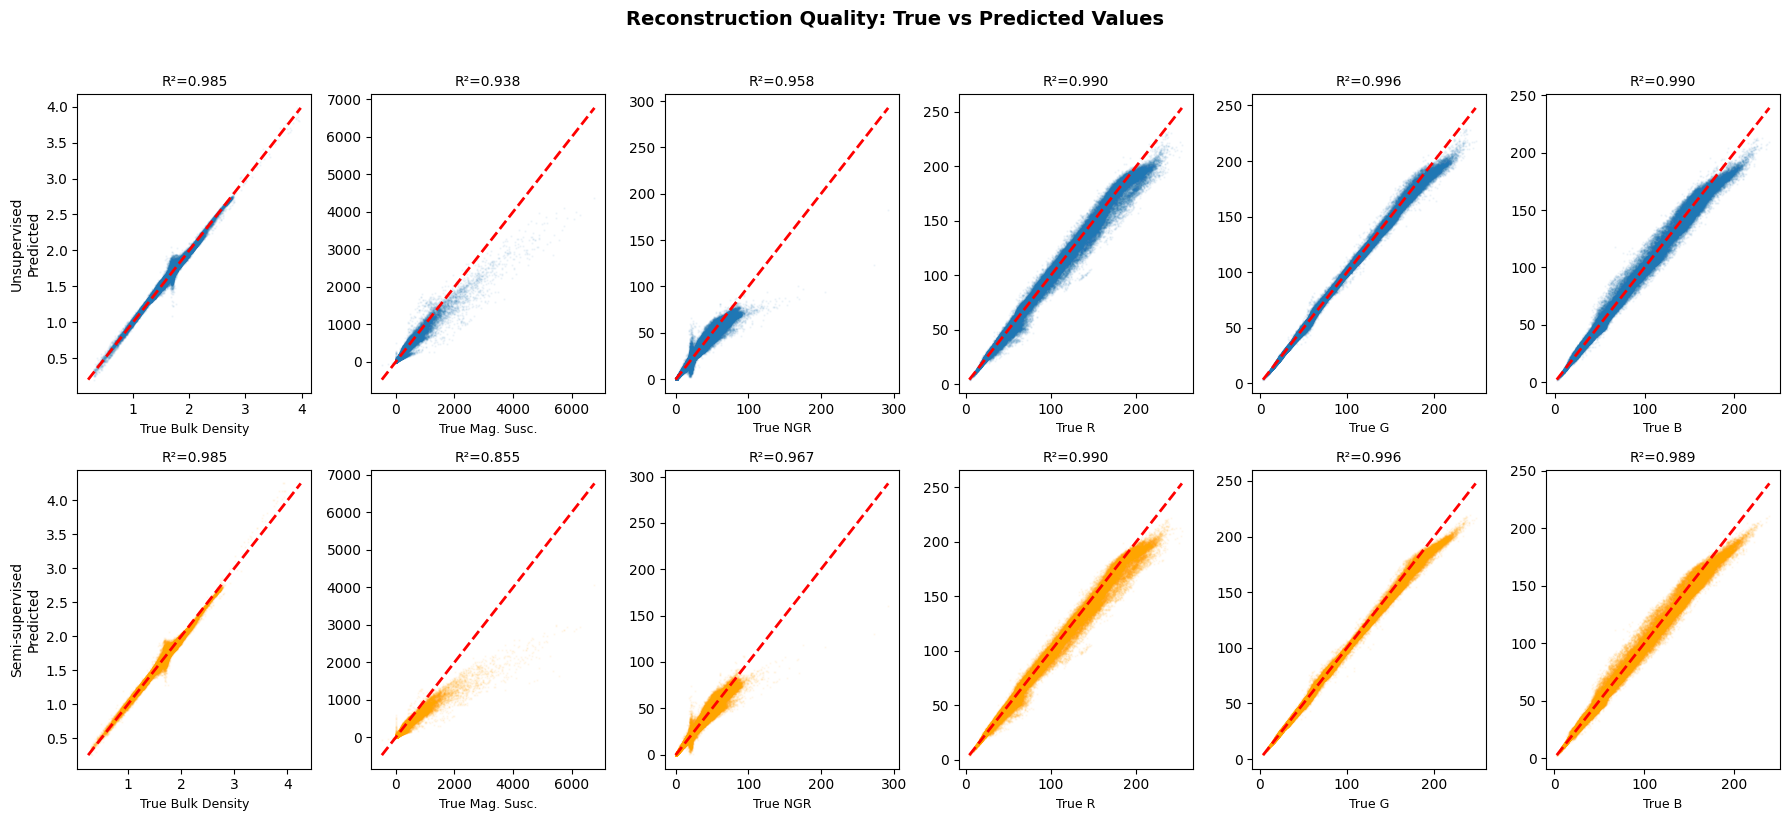

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_reconstruction_scatter.png


In [28]:
# Inverse transform to original scale for visualization
X_orig_raw = scaler.inverse_transform(X_scaled)
X_unsup_raw = scaler.inverse_transform(recon_unsup)
X_semisup_raw = scaler.inverse_transform(recon_semisup)

fig, axes = plt.subplots(2, 6, figsize=(18, 8))

# Different colors for each variable
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, (name, color) in enumerate(zip(FEATURE_NAMES_SHORT, colors)):
    # Unsupervised (top row)
    ax = axes[0, i]
    r2 = r2_score(X_orig_raw[:, i], X_unsup_raw[:, i])
    ax.scatter(X_orig_raw[:, i], X_unsup_raw[:, i], alpha=0.05, s=0.5, c=color, rasterized=True)
    
    # Reference line
    lims = [min(X_orig_raw[:, i].min(), X_unsup_raw[:, i].min()),
            max(X_orig_raw[:, i].max(), X_unsup_raw[:, i].max())]
    ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.7)
    
    # Text box with variable name and R²
    textstr = f'{name}\nR² = {r2:.3f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    ax.set_xlabel(f'True', fontsize=9)
    if i == 0:
        ax.set_ylabel('Unsupervised\nPredicted', fontsize=10)
    ax.tick_params(labelsize=8)
    
    # Semi-supervised (bottom row)
    ax = axes[1, i]
    r2 = r2_score(X_orig_raw[:, i], X_semisup_raw[:, i])
    ax.scatter(X_orig_raw[:, i], X_semisup_raw[:, i], alpha=0.05, s=0.5, c=color, rasterized=True)
    
    lims = [min(X_orig_raw[:, i].min(), X_semisup_raw[:, i].min()),
            max(X_orig_raw[:, i].max(), X_semisup_raw[:, i].max())]
    ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.7)
    
    # Text box with variable name and R²
    textstr = f'{name}\nR² = {r2:.3f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)
    
    ax.set_xlabel(f'True', fontsize=9)
    if i == 0:
        ax.set_ylabel('Semi-supervised\nPredicted', fontsize=10)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_reconstruction_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_reconstruction_scatter.png'}")

### 12.2 ROC Comparison

In [29]:
# Get top 10 classes for ROC curve visualization
class_counts = np.bincount(y)
top10_classes = np.argsort(class_counts)[-10:]

# Subsample for computational efficiency
n_roc_samples = min(20000, len(y))
roc_idx = np.random.choice(len(y), n_roc_samples, replace=False)

# Filter to top 10 classes
mask = np.isin(y[roc_idx], top10_classes)
y_roc = y[roc_idx][mask]
emb_unsup_roc = emb_unsup[roc_idx][mask]
emb_semisup_roc = emb_semisup[roc_idx][mask]

# Binarize labels
y_bin = label_binarize(y_roc, classes=top10_classes)

print(f"ROC analysis on {len(y_roc):,} samples from top 10 classes")

ROC analysis on 14,281 samples from top 10 classes


Training SVM for unsupervised ROC...


Computing semi-supervised ROC...


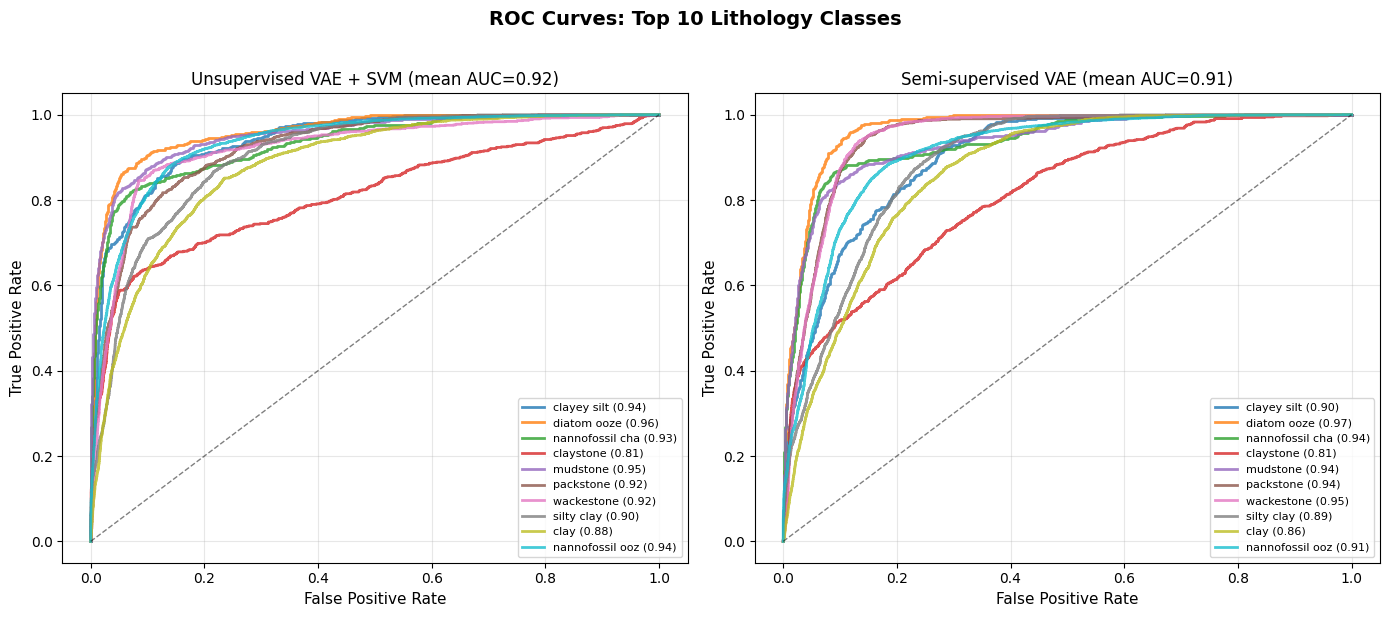

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_roc_comparison.png


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Unsupervised (SVM)
print("Training SVM for unsupervised ROC...")
svm_roc = OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=SEED))
svm_roc.fit(emb_unsup_roc, y_bin)
y_score_unsup = svm_roc.predict_proba(emb_unsup_roc)

ax = axes[0]
mean_auc_unsup = 0
for i, cls in enumerate(top10_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score_unsup[:, i])
    roc_auc = auc(fpr, tpr)
    mean_auc_unsup += roc_auc
    name = label_encoder.inverse_transform([cls])[0][:15]
    ax.plot(fpr, tpr, lw=2, alpha=0.8, color=colors[i], label=f'{name} ({roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title(f'Unsupervised VAE + SVM\n(mean AUC = {mean_auc_unsup/10:.2f})', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Semi-supervised (classification head)
print("Computing semi-supervised ROC...")
_, y_prob_roc = get_predictions(model_semisup, X_scaled[roc_idx][mask])
y_score_semisup = y_prob_roc[:, top10_classes]

ax = axes[1]
mean_auc_semisup = 0
for i, cls in enumerate(top10_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score_semisup[:, i])
    roc_auc = auc(fpr, tpr)
    mean_auc_semisup += roc_auc
    name = label_encoder.inverse_transform([cls])[0][:15]
    ax.plot(fpr, tpr, lw=2, alpha=0.8, color=colors[i], label=f'{name} ({roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title(f'Semi-supervised VAE\n(mean AUC = {mean_auc_semisup/10:.2f})', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_roc_comparison.png'}")

### 12.3 R² Comparison Plot

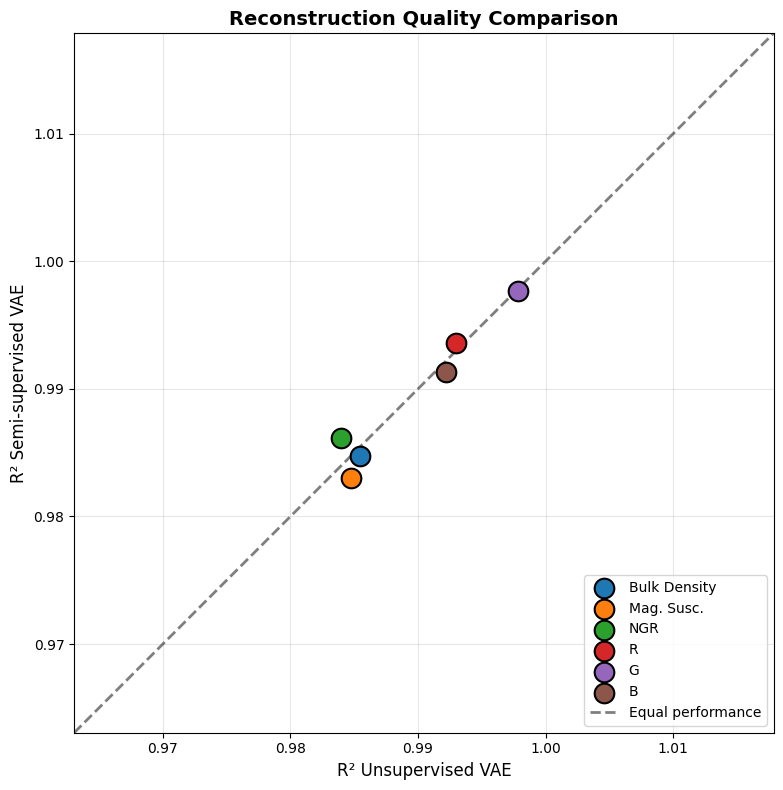

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_r2_unsup_vs_semi.png


In [31]:
# R² comparison with 95% confidence intervals per lithology class
# Following scripts/fig_r2_scatter_with_ci.py logic

def compute_r2_standard_error(r2: float, n: int) -> float:
    """Approximate standard error of R² using analytical formula."""
    r2_clip = np.clip(r2, 0.01, 0.99)
    return np.sqrt((1 - r2_clip)**2 * 4 * r2_clip / n)

# Compute per-class R² scores
class_r2_results = []
for cls in range(n_classes):
    mask = y == cls
    n_samples = mask.sum()
    if n_samples < 50:  # Skip classes with too few samples
        continue
    
    # Get class samples
    X_cls = X_scaled[mask]
    X_unsup_cls = recon_unsup[mask]
    X_semisup_cls = recon_semisup[mask]
    
    # Compute R² for unsupervised and semi-supervised
    r2_unsup = r2_score(X_cls.flatten(), X_unsup_cls.flatten())
    r2_semisup = r2_score(X_cls.flatten(), X_semisup_cls.flatten())
    
    class_name = label_encoder.inverse_transform([cls])[0]
    class_r2_results.append({
        'class': cls,
        'name': class_name,
        'n_samples': n_samples,
        'r2_unsup': r2_unsup,
        'r2_semisup': r2_semisup
    })

results_df = pd.DataFrame(class_r2_results)

# Add confidence intervals
results_df['r2_unsup_se'] = results_df.apply(
    lambda row: compute_r2_standard_error(row['r2_unsup'], row['n_samples']), axis=1)
results_df['r2_semisup_se'] = results_df.apply(
    lambda row: compute_r2_standard_error(row['r2_semisup'], row['n_samples']), axis=1)

fig, ax = plt.subplots(figsize=(10, 10))

x = results_df['r2_semisup'].values
y_vals = results_df['r2_unsup'].values
xerr = results_df['r2_semisup_se'].values * 1.96  # 95% CI
yerr = results_df['r2_unsup_se'].values * 1.96
n_samples = results_df['n_samples'].values

# Scale point size by log of sample count
log_samples = np.log10(np.clip(n_samples, 100, 1e6))
sizes = 30 + 150 * (log_samples - 2) / 4

# Color: Cyan if semi-supervised wins, Pink if unsupervised wins
colors = ['#00BCD4' if xi > yi else '#E91E63' for xi, yi in zip(x, y_vals)]

# Count wins
semisup_wins = sum(1 for xi, yi in zip(x, y_vals) if xi > yi)
unsup_wins = sum(1 for xi, yi in zip(x, y_vals) if yi > xi)

print(f"Semi-supervised wins: {semisup_wins}")
print(f"Unsupervised wins: {unsup_wins}")

# Error bars (lighter color, behind points)
for i in range(len(x)):
    ax.errorbar(x[i], y_vals[i], xerr=xerr[i], yerr=yerr[i], 
                fmt='none', ecolor=colors[i], alpha=0.3, capsize=0, zorder=1)

# Scatter points on top
for i in range(len(x)):
    ax.scatter(x[i], y_vals[i], s=sizes[i], c=colors[i], alpha=0.7, 
               edgecolors='white', linewidth=0.5, zorder=2)

# Diagonal line (y = x)
ax.plot([-0.2, 1.05], [-0.2, 1.05], 'k--', lw=1.5, alpha=0.5)

# Labels
ax.set_xlabel('Semi-supervised R²', fontsize=14)
ax.set_ylabel('Unsupervised R²', fontsize=14)
ax.set_xlim(-0.2, 1.05)
ax.set_ylim(-0.2, 1.05)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend for colors
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#00BCD4', 
           markersize=10, label=f'Semi-supervised better ({semisup_wins})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#E91E63', 
           markersize=10, label=f'Unsupervised better ({unsup_wins})'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

# Size legend
size_legend_ax = fig.add_axes([0.15, 0.72, 0.15, 0.18])
size_legend_ax.set_xlim(0, 1)
size_legend_ax.set_ylim(0, 1)
size_legend_ax.axis('off')

for ss, label, yp in [(100, '100', 0.85), (1000, '1k', 0.65), 
                       (10000, '10k', 0.45), (100000, '100k', 0.25)]:
    log_s = np.log10(ss)
    size = 30 + 150 * (log_s - 2) / 4
    size_legend_ax.scatter(0.3, yp, s=size, c='gray', alpha=0.7, edgecolors='white')
    size_legend_ax.text(0.6, yp, label, va='center', fontsize=10)
size_legend_ax.text(0.4, 1.0, 'n', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_r2_unsup_vs_semi.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_r2_unsup_vs_semi.png'}")

### 12.4 UMAP Visualization

In [32]:
# UMAP embedding visualization
print("Computing UMAP embeddings (this may take a few minutes)...")

# Subsample for UMAP
n_umap_samples = min(50000, len(y))
umap_idx = np.random.choice(len(y), n_umap_samples, replace=False)

# Get top 15 classes for coloring
top15_classes = set(np.argsort(class_counts)[-15:])

print(f"Computing UMAP for {n_umap_samples:,} samples...")

# UMAP for unsupervised
print("  Unsupervised embeddings...")
reducer_unsup = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED, n_jobs=-1)
umap_unsup = reducer_unsup.fit_transform(emb_unsup[umap_idx])

# UMAP for semi-supervised
print("  Semi-supervised embeddings...")
reducer_semisup = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED, n_jobs=-1)
umap_semisup = reducer_semisup.fit_transform(emb_semisup[umap_idx])

print("  Done!")

Computing UMAP embeddings (this may take a few minutes)...
Computing UMAP for 50,000 samples...
  Unsupervised embeddings...


  Semi-supervised embeddings...


  Done!


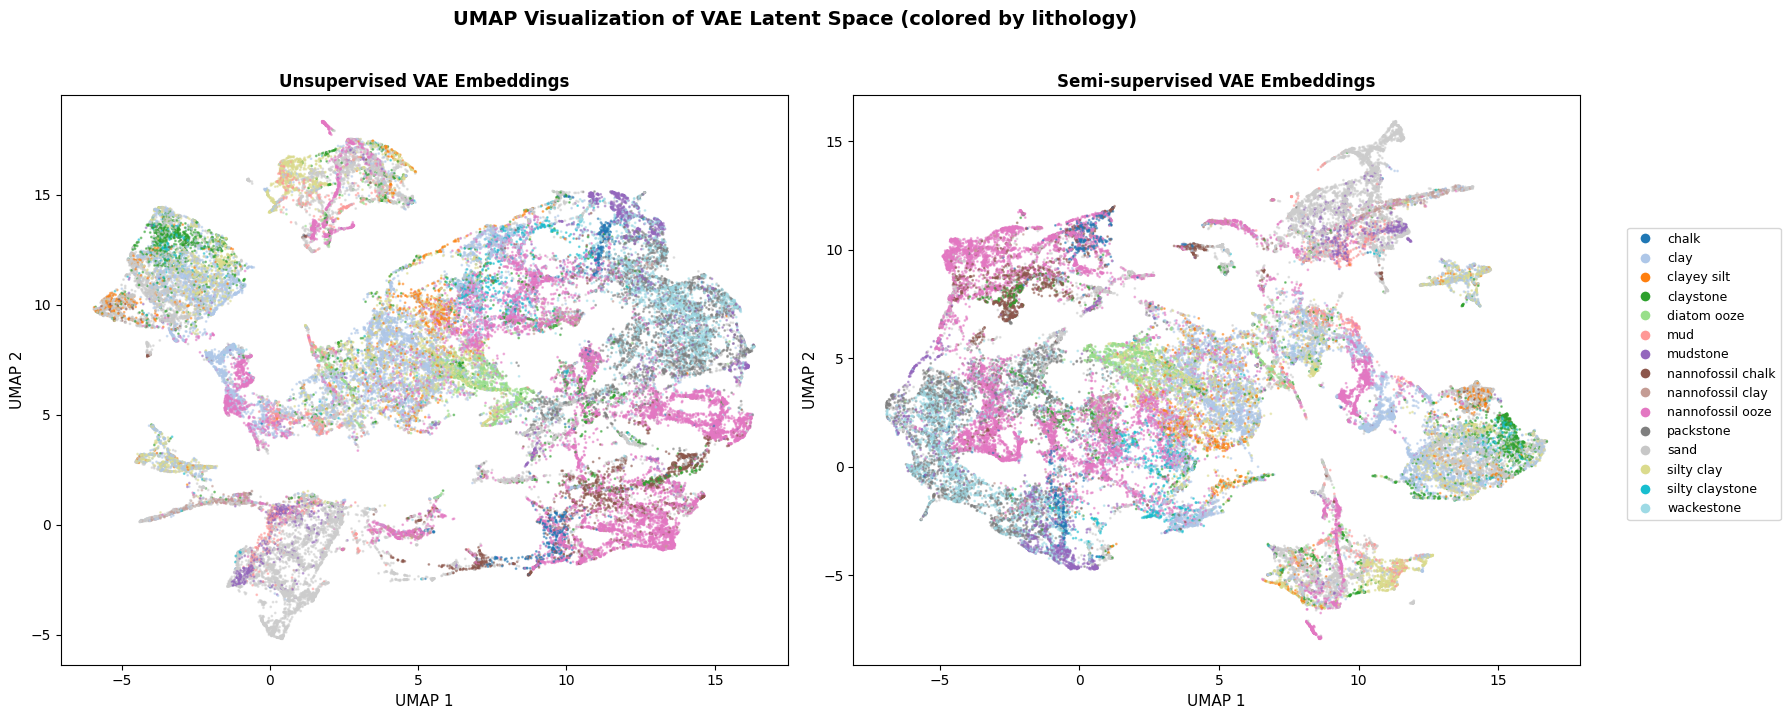

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_umap_lithology.png


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

y_sub = y[umap_idx]

# Create color array
cmap = plt.cm.tab20(np.linspace(0, 1, 15))
colors = np.array(['#CCCCCC'] * len(y_sub))
for i, cls in enumerate(sorted(top15_classes)):
    colors[y_sub == cls] = matplotlib.colors.to_hex(cmap[i])

# Unsupervised
ax = axes[0]
ax.scatter(umap_unsup[:, 0], umap_unsup[:, 1], c=colors, s=1, alpha=0.5, rasterized=True)
ax.set_title('Unsupervised', fontsize=14, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Semi-supervised
ax = axes[1]
ax.scatter(umap_semisup[:, 0], umap_semisup[:, 1], c=colors, s=1, alpha=0.5, rasterized=True)
ax.set_title('Semi-supervised', fontsize=14, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Legend at bottom
handles = []
for i, cls in enumerate(sorted(top15_classes)):
    name = label_encoder.inverse_transform([cls])[0][:20]
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                               markerfacecolor=matplotlib.colors.to_hex(cmap[i]),
                               markersize=8, label=name))

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), 
           ncol=5, fontsize=9, frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig(FIGURES_DIR / 'fig_umap_lithology.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_umap_lithology.png'}")

## 13. Network Diagrams

In [34]:
def draw_vae_architecture(ax, model_type='unsupervised', n_classes=None):
    """
    Draw VAE architecture diagram.
    
    Parameters
    ----------
    ax : matplotlib axis
    model_type : str
        'unsupervised' or 'semi-supervised'
    n_classes : int
        Number of classes (for semi-supervised)
    """
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Colors
    input_color = '#90EE90'   # Light green
    hidden_color = '#87CEEB'  # Sky blue
    latent_color = '#FFD700'  # Gold
    output_color = '#FFA07A'  # Light salmon
    class_color = '#DDA0DD'   # Plum
    
    # Layer positions (x)
    x_input = 1
    x_enc1 = 2.5
    x_enc2 = 4
    x_latent = 5.5
    x_dec1 = 7
    x_dec2 = 8.5
    x_output = 10
    
    # Main path y-position
    y_main = 3
    
    # Draw boxes
    def draw_box(x, y, w, h, color, text, fontsize=9):
        rect = plt.Rectangle((x - w/2, y - h/2), w, h, 
                             facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, fontweight='bold')
    
    # Draw arrow
    def draw_arrow(x1, y1, x2, y2, style='-'):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5, ls=style))
    
    # Input
    draw_box(x_input, y_main, 0.8, 1.2, input_color, 'Input\n(6)')
    
    # Encoder
    draw_box(x_enc1, y_main, 0.8, 1.2, hidden_color, 'FC\n64\nBN')
    draw_box(x_enc2, y_main, 0.8, 1.2, hidden_color, 'FC\n32\nBN')
    
    # Latent (mu and logvar)
    draw_box(x_latent, y_main + 0.7, 0.8, 0.8, latent_color, 'μ (10)')
    draw_box(x_latent, y_main - 0.7, 0.8, 0.8, latent_color, 'σ² (10)')
    
    # Decoder
    draw_box(x_dec1, y_main, 0.8, 1.2, hidden_color, 'FC\n32\nBN')
    draw_box(x_dec2, y_main, 0.8, 1.2, hidden_color, 'FC\n64\nBN')
    
    # Output
    draw_box(x_output - 0.5, y_main, 0.8, 1.2, output_color, 'Output\n(6)')
    
    # Arrows - encoder
    draw_arrow(x_input + 0.4, y_main, x_enc1 - 0.4, y_main)
    draw_arrow(x_enc1 + 0.4, y_main, x_enc2 - 0.4, y_main)
    draw_arrow(x_enc2 + 0.4, y_main + 0.2, x_latent - 0.4, y_main + 0.7)
    draw_arrow(x_enc2 + 0.4, y_main - 0.2, x_latent - 0.4, y_main - 0.7)
    
    # Sampling (z)
    ax.text(x_latent + 0.6, y_main, 'z', fontsize=12, fontweight='bold', ha='center', va='center')
    draw_arrow(x_latent + 0.4, y_main + 0.5, x_latent + 0.6, y_main + 0.1)
    draw_arrow(x_latent + 0.4, y_main - 0.5, x_latent + 0.6, y_main - 0.1)
    
    # Arrows - decoder
    draw_arrow(x_latent + 0.8, y_main, x_dec1 - 0.4, y_main)
    draw_arrow(x_dec1 + 0.4, y_main, x_dec2 - 0.4, y_main)
    draw_arrow(x_dec2 + 0.4, y_main, x_output - 0.5 - 0.4, y_main)
    
    # Classification head for semi-supervised
    if model_type == 'semi-supervised' and n_classes:
        y_class = 1.2
        draw_box(x_dec1, y_class, 0.8, 0.8, class_color, 'FC\n64')
        draw_box(x_dec2, y_class, 0.8, 0.8, class_color, f'FC\n{n_classes}')
        
        # Arrows from z to classifier
        draw_arrow(x_latent + 0.6, y_main - 0.3, x_dec1 - 0.4, y_class)
        draw_arrow(x_dec1 + 0.4, y_class, x_dec2 - 0.4, y_class)
        
        # Label
        ax.text(x_dec2 + 0.8, y_class, 'Classes', fontsize=10, ha='left', va='center')
    
    # Labels
    ax.text(x_enc1 + 0.75, y_main + 1.5, 'Encoder', fontsize=11, ha='center', fontweight='bold')
    ax.text(x_dec1 + 0.75, y_main + 1.5, 'Decoder', fontsize=11, ha='center', fontweight='bold')
    ax.text(x_latent, y_main + 1.8, 'Latent Space', fontsize=11, ha='center', fontweight='bold')

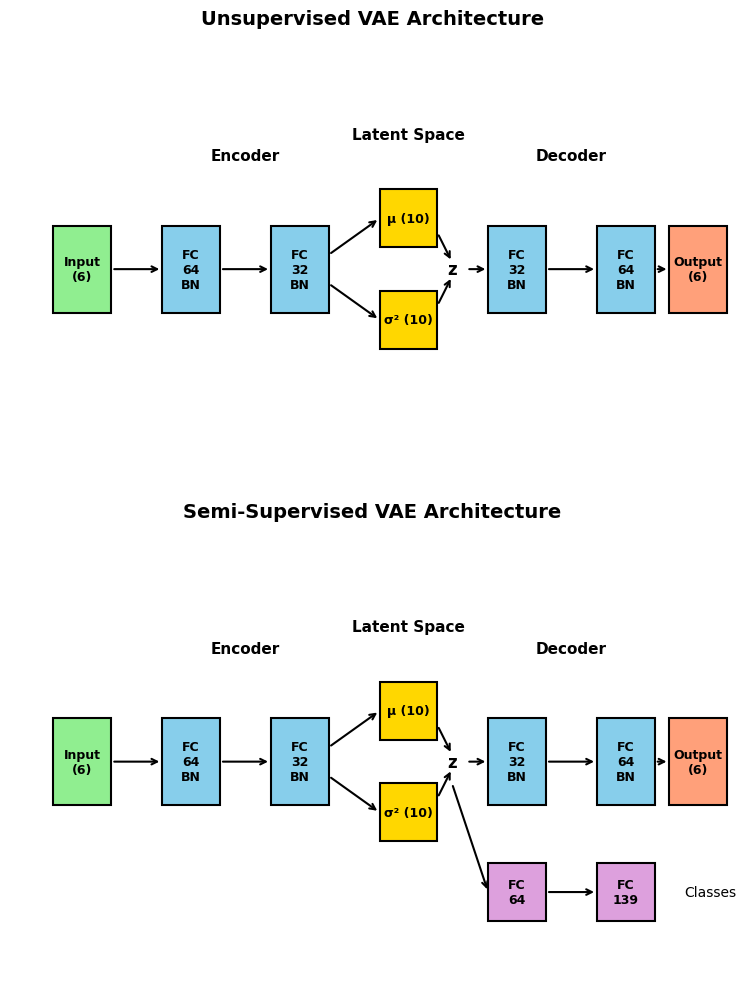

Saved: /home/mnky9800n/clawd/bhai-vae-paper/figures/fig_network_diagrams.png


In [35]:
# Draw both architectures
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Unsupervised
ax = axes[0]
draw_vae_architecture(ax, model_type='unsupervised')
ax.set_title('Unsupervised VAE Architecture', fontsize=14, fontweight='bold', pad=20)

# Semi-supervised
ax = axes[1]
draw_vae_architecture(ax, model_type='semi-supervised', n_classes=n_classes)
ax.set_title('Semi-Supervised VAE Architecture', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_network_diagrams.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig_network_diagrams.png'}")

## 14. Summary and Export

In [36]:
# Final summary
print("="*70)
print("BHAI VAE PAPER NOTEBOOK - SUMMARY")
print("="*70)
print(f"\nTimestamp: {datetime.now().isoformat()}")
print(f"Device: {DEVICE}")
print(f"Random seed: {SEED}")

print(f"\n--- Dataset ---")
print(f"Total samples: {len(df):,}")
print(f"Total boreholes: {df['Borehole_ID'].nunique():,}")
print(f"Expeditions: {len(expeditions)}")
print(f"Lithology classes: {n_classes}")

print(f"\n--- Model Architecture ---")
print(f"Input dim: {INPUT_DIM}")
print(f"Latent dim: {LATENT_DIM}")
print(f"Hidden dims: {HIDDEN_DIMS}")

print(f"\n--- Training ---")
print(f"Epochs: {N_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Mask ratio: {MASK_RATIO}")
print(f"β-annealing: {BETA_START} → {BETA_END} over {BETA_ANNEAL_EPOCHS} epochs")
print(f"α-annealing: {ALPHA_START} → {ALPHA_END} over {ALPHA_ANNEAL_EPOCHS} epochs")

print(f"\n--- Results ---")
print(f"Unsupervised VAE:")
print(f"  R² (overall): {r2_overall_unsup:.4f}")
print(f"  SVM Accuracy: {acc_svm:.4f}")
print(f"\nSemi-supervised VAE:")
print(f"  R² (overall): {r2_overall_semisup:.4f}")
print(f"  Classification Accuracy: {acc_semisup:.4f}")

print(f"\n--- Generated Files ---")
print(f"Models:")
for f in MODEL_DIR.glob('*.pt'):
    print(f"  {f.name}")
print(f"\nFigures:")
for f in sorted(FIGURES_DIR.glob('fig_*.png')):
    print(f"  {f.name}")

print("\n" + "="*70)
print("COMPLETE")
print("="*70)

BHAI VAE PAPER NOTEBOOK - SUMMARY

Timestamp: 2026-02-06T10:23:11.296017
Device: cuda:0
Random seed: 42

--- Dataset ---
Total samples: 238,506
Total boreholes: 296
Expeditions: 24
Lithology classes: 139

--- Model Architecture ---
Input dim: 6
Latent dim: 10
Hidden dims: [64, 32]

--- Training ---
Epochs: 100
Batch size: 256
Mask ratio: 0.1
β-annealing: 1e-10 → 0.075 over 50 epochs
α-annealing: 0.0 → 0.01 over 50 epochs

--- Results ---
Unsupervised VAE:
  R² (overall): 0.9895
  SVM Accuracy: 0.5255

Semi-supervised VAE:
  R² (overall): 0.9894
  Classification Accuracy: 0.4539

--- Generated Files ---
Models:
  model_unsup_hybrid.pt
  model_semisup.pt
  model_semisup_hybrid.pt
  model_unsup.pt
  semisup.pt
  unsup.pt

Figures:
  fig_generated_variables_grid.png
  fig_lily_dataset.png
  fig_lily_expedition_map.png
  fig_lily_lithology_counts.png
  fig_lily_variables_dist.png
  fig_network_diagrams.png
  fig_r2_unsup_vs_semi.png
  fig_reconstruction_scatter.png
  fig_roc_comparison.png
